#FB Prophet implementation

**Summary**


**Data**: AAPL stock

**Granularity**: daily data

**Source**: Yahoo! Finance

**Time period**: 2010-01-04 / 2022-12-30

**Model**: FB Prophet


# Importing Libraries

In [ ]:
# Install Prophet library
!pip install prophet

# Required packages
import pandas as pd
import numpy as np
import datetime
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

# To plot data
import matplotlib.pyplot as plt
from prophet.plot import plot_plotly, plot_components_plotly
import seaborn as sns
sns.set()

# Load the data

In [4]:
file_path = "/content/AAPL.csv"
data = pd.read_csv(file_path)
data.Date = pd.to_datetime(data.Date)
data.set_index("Date", inplace = True)

In [5]:
# Define log returns as a new variable
log_returns = np.log(data["Adj Close"]).diff(1)
data["log_returns"] = log_returns

In [6]:
# Filter the dataset
data = data[["log_returns", "Adj Close"]]

For the purpose of this analysis, we keep only two columns of the dataset, "log_returns" and "Adj Close" variables in order to experiment with Prophet predicting ability.



# Train-Test Split

In [7]:
train_df = data.loc[:"2020-12-31"]
test_df = data.loc["2021-01-01":]
print(train_df.shape)
print(test_df.shape)

(2769, 2)
(503, 2)


# Prophet

##Prophet - Log Returns

### Data processing

In [8]:
# Reshape the dataset for fitting a Prophet model
returns_df = pd.DataFrame(columns = ["ds", "y"])
returns_df["ds"] = data.index
returns_df["y"] = data["log_returns"].values

After having shaped the original dataset according to Prophet's requirements, we further split it into train and test sets.

In [9]:
returns_train_df = pd.DataFrame(columns = ["ds", "y"])
returns_train_df["ds"] = train_df.index
returns_train_df["y"] = train_df["log_returns"].values

In [10]:
returns_test_df = pd.DataFrame(columns = ["ds", "y"])
returns_test_df["ds"] = test_df.index
returns_test_df["y"] = test_df["log_returns"].values

### Fitting Model

In [ ]:
returns_model = Prophet()
returns_model.fit(returns_train_df)

### Making Predictions on the test set

In [12]:
# Make predictions on the test data, using a daily frequency
future_df_returns = returns_model.make_future_dataframe(periods=len(returns_test_df.index), freq = "D")

In [13]:
# Predict future log returns
returns_predictions_df = returns_model.predict(future_df_returns)

In [14]:
# Visualize predictions results
returns_predictions_df.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-04,0.001449,-0.018920,0.029031,0.001449,0.001449,0.003045,0.003045,0.003045,0.002621,0.002621,0.002621,0.000425,0.000425,0.000425,0.0,0.0,0.0,0.004495
1,2010-01-05,0.001449,-0.019033,0.025473,0.001449,0.001449,0.000849,0.000849,0.000849,0.000561,0.000561,0.000561,0.000289,0.000289,0.000289,0.0,0.0,0.0,0.002298
2,2010-01-06,0.001448,-0.020473,0.025319,0.001448,0.001448,0.000837,0.000837,0.000837,0.000720,0.000720,0.000720,0.000117,0.000117,0.000117,0.0,0.0,0.0,0.002286
3,2010-01-07,0.001448,-0.024073,0.022021,0.001448,0.001448,-0.001981,-0.001981,-0.001981,-0.001896,-0.001896,-0.001896,-0.000085,-0.000085,-0.000085,0.0,0.0,0.0,-0.000533
4,2010-01-08,0.001447,-0.026341,0.021343,0.001447,0.001447,-0.002594,-0.002594,-0.002594,-0.002283,-0.002283,-0.002283,-0.000311,-0.000311,-0.000311,0.0,0.0,0.0,-0.001147


### Plotting Forecasts and Components

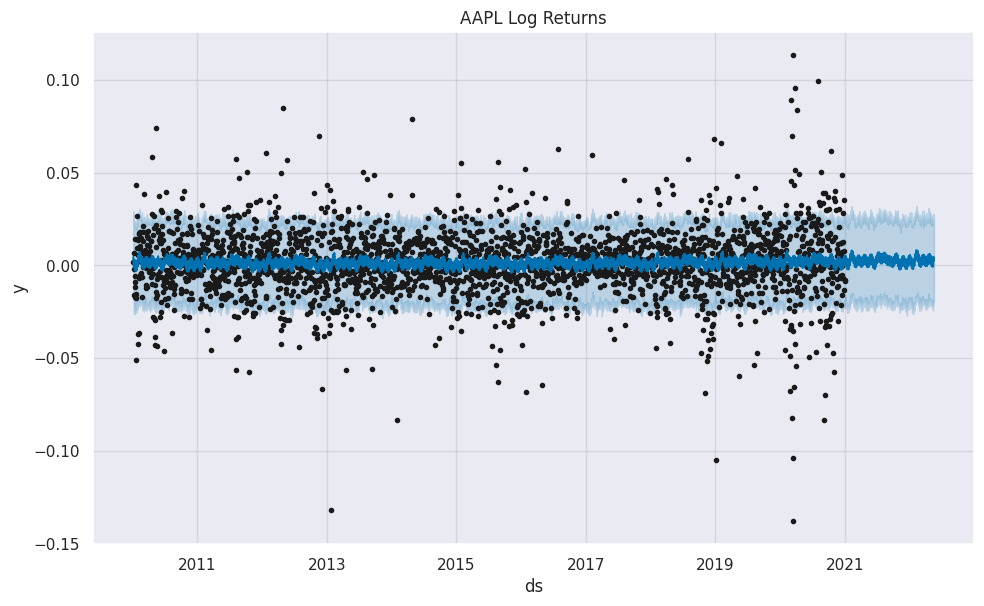

In [15]:
# Plot the log returns
returns_model.plot(returns_predictions_df)
plt.title("AAPL Log Returns")
plt.show()

In [16]:
# Interactive plot
plot_plotly(returns_model, returns_predictions_df)

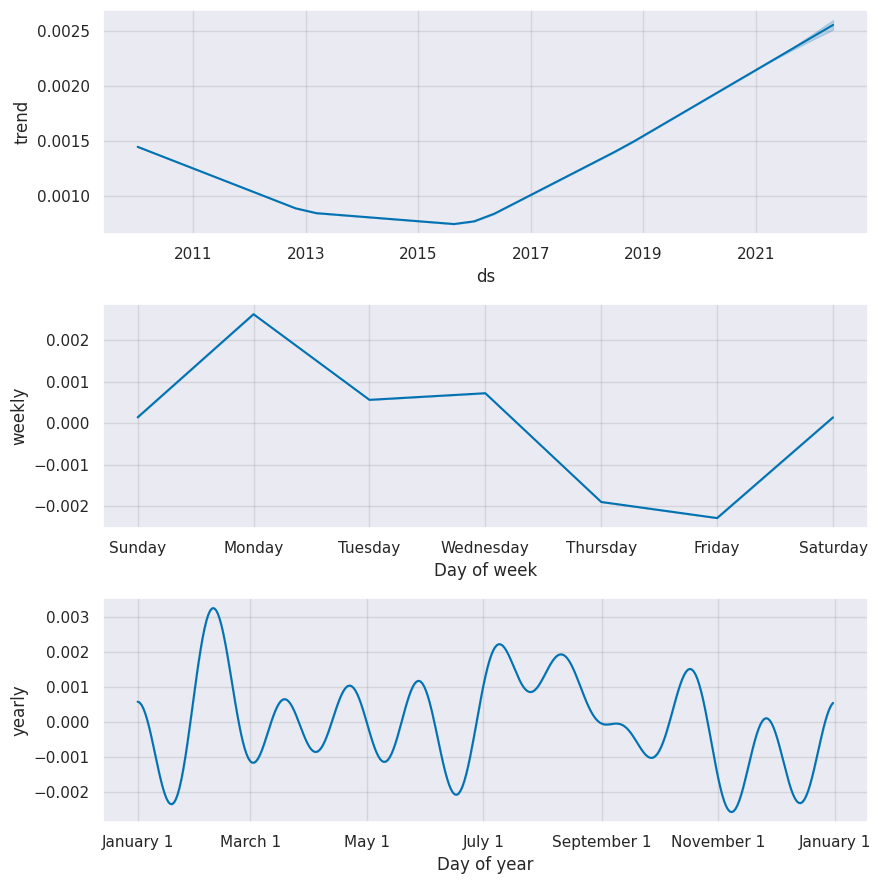

In [17]:
# Plot model components
returns_model.plot_components(returns_predictions_df)
plt.show()

Over the years, we observe an increasing trend, especialy after 2016. Looking at a weekly perspective, returns seem to be lower on friday, compared to the rest of the week.

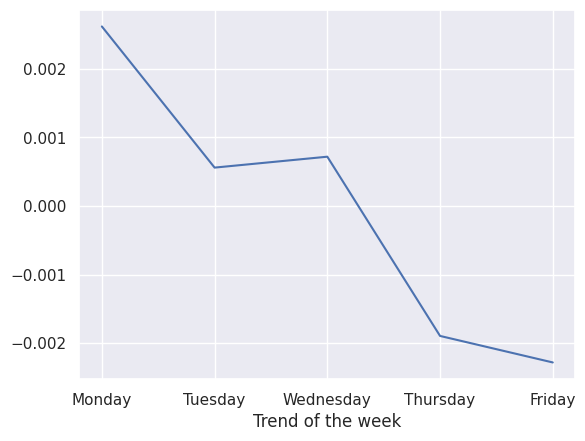

In [18]:
# Look at five-days week seasonality
s = 0

while(True):
  if returns_predictions_df.ds[s].weekday() == 0:
    break
  else:
    s += 1
e = s + 5

days = returns_predictions_df.ds[s: e]
weekly_seasonality = returns_predictions_df.weekly[s: e]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(np.arange(5), weekly_seasonality)
ax.set_xticks(np.arange(5))
ax.set_xticklabels(days.dt.day_name())
ax.set_xlabel('Trend of the week')

plt.show()

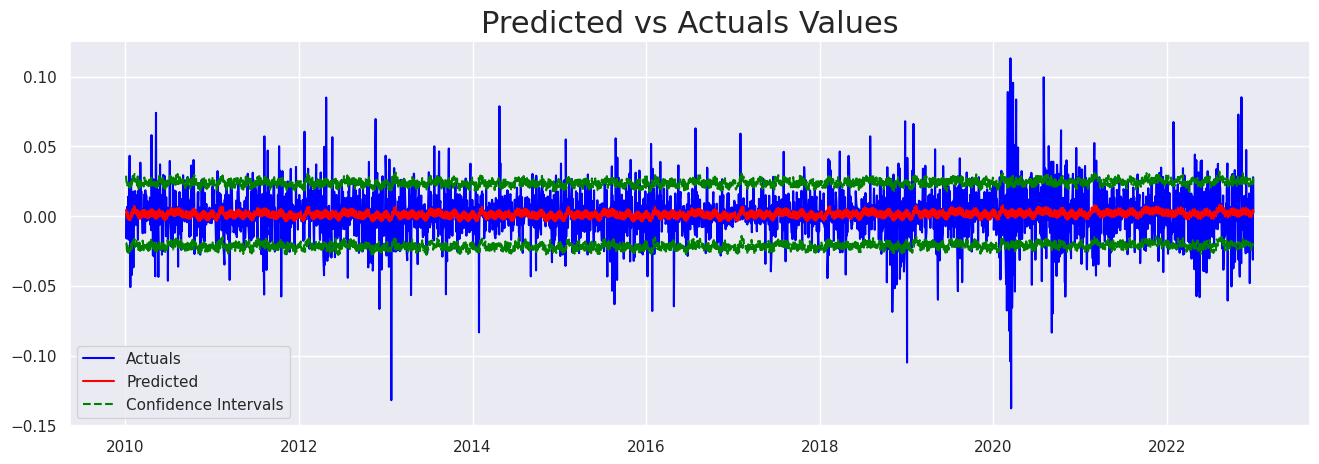

In [19]:
plt.rcParams["figure.figsize"] = 16, 5

plt.plot(data["log_returns"], color = "blue", label = "Actuals")
plt.plot(data.index, returns_predictions_df["yhat"], color = "red", label = "Predicted")
plt.plot(data.index, returns_predictions_df["yhat_lower"], color = "green", linestyle = "--", label = "Confidence Intervals")
plt.plot(data.index, returns_predictions_df["yhat_upper"], color = "green", linestyle = "--")

plt.title("Predicted vs Actuals Values", size = 22)
plt.legend()
plt.show()

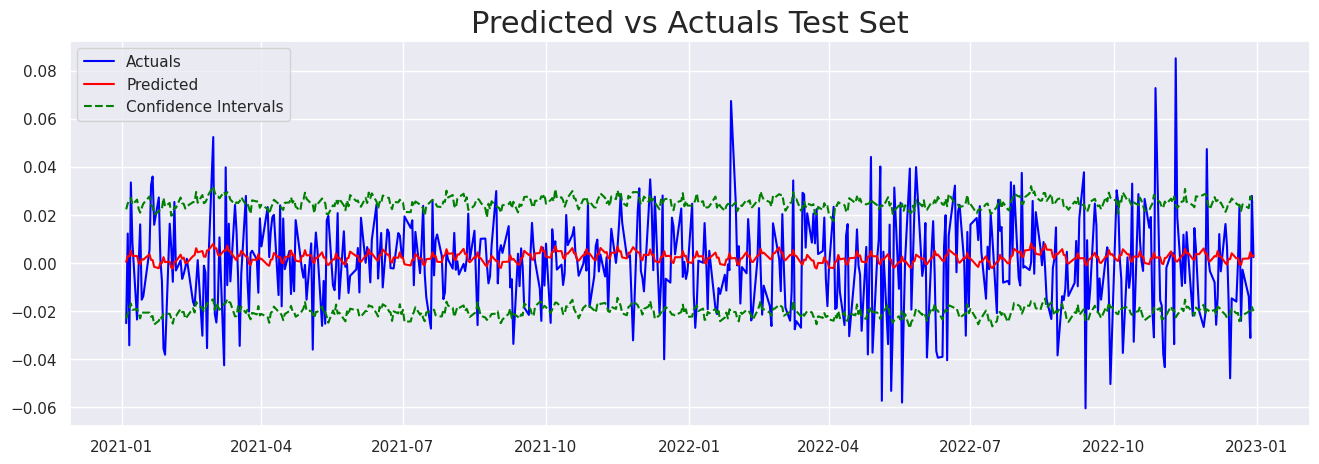

In [20]:
plt.rcParams["figure.figsize"] = 16, 5

plt.plot(test_df["log_returns"], color = "blue", label = "Actuals")
plt.plot(test_df.index, returns_predictions_df.loc[returns_train_df.index[-1]+1:]["yhat"], color = "red", label = "Predicted")
plt.plot(test_df.index, returns_predictions_df.loc[returns_train_df.index[-1]+1:]["yhat_lower"], color = "green", linestyle = "--", label = "Confidence Intervals")
plt.plot(test_df.index, returns_predictions_df.loc[returns_train_df.index[-1]+1:]["yhat_upper"], color = "green", linestyle = "--")

plt.title("Predicted vs Actuals Test Set", size = 22)
plt.legend()
plt.show()

### Get the MSE and RMSE

In [21]:
# Get the RMSE
y_true = returns_test_df["y"].values
y_pred = returns_predictions_df["yhat"][-len(returns_test_df.index):].values
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("MSE:", mse)
print("RMSE:", rmse)

MSE: 0.00039351322348642713
RMSE: 0.019837167728444176


## Prophet - Adj Close

### Data processing

In [22]:
prices_df = pd.DataFrame(columns = ["ds", "y"])
prices_df["ds"] = data.index
prices_df["y"] = data["Adj Close"].values

In [23]:
prices_train_df = pd.DataFrame(columns = ["ds", "y"])
prices_train_df["ds"] = train_df.index
prices_train_df["y"] = train_df["Adj Close"].values

In [24]:
prices_test_df = pd.DataFrame(columns = ["ds", "y"])
prices_test_df["ds"] = test_df.index
prices_test_df["y"] = test_df["Adj Close"].values

### Fitting Model

In [ ]:
prices_model = Prophet()
prices_model.fit(prices_train_df)

### Making Predictions

In [26]:
future_df = prices_model.make_future_dataframe(periods=len(prices_test_df.index), freq = "D")

In [27]:
prices_predictions_df = prices_model.predict(future_df)

In [28]:
# Visualize predictions results
prices_predictions_df.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-04,6.715878,-0.109881,13.592168,6.715878,6.715878,-0.038063,-0.038063,-0.038063,0.045802,0.045802,0.045802,-0.083865,-0.083865,-0.083865,0.0,0.0,0.0,6.677815
1,2010-01-05,6.723738,-0.585415,13.447517,6.723738,6.723738,-0.125251,-0.125251,-0.125251,0.081999,0.081999,0.081999,-0.207250,-0.207250,-0.207250,0.0,0.0,0.0,6.598487
2,2010-01-06,6.731598,-0.219360,13.481706,6.731598,6.731598,-0.213229,-0.213229,-0.213229,0.114935,0.114935,0.114935,-0.328165,-0.328165,-0.328165,0.0,0.0,0.0,6.518369
3,2010-01-07,6.739459,-1.290848,13.069801,6.739459,6.739459,-0.354077,-0.354077,-0.354077,0.091333,0.091333,0.091333,-0.445410,-0.445410,-0.445410,0.0,0.0,0.0,6.385382
4,2010-01-08,6.747319,-0.523547,12.366806,6.747319,6.747319,-0.615029,-0.615029,-0.615029,-0.057153,-0.057153,-0.057153,-0.557875,-0.557875,-0.557875,0.0,0.0,0.0,6.132290


### Plotting Forecasts and Components

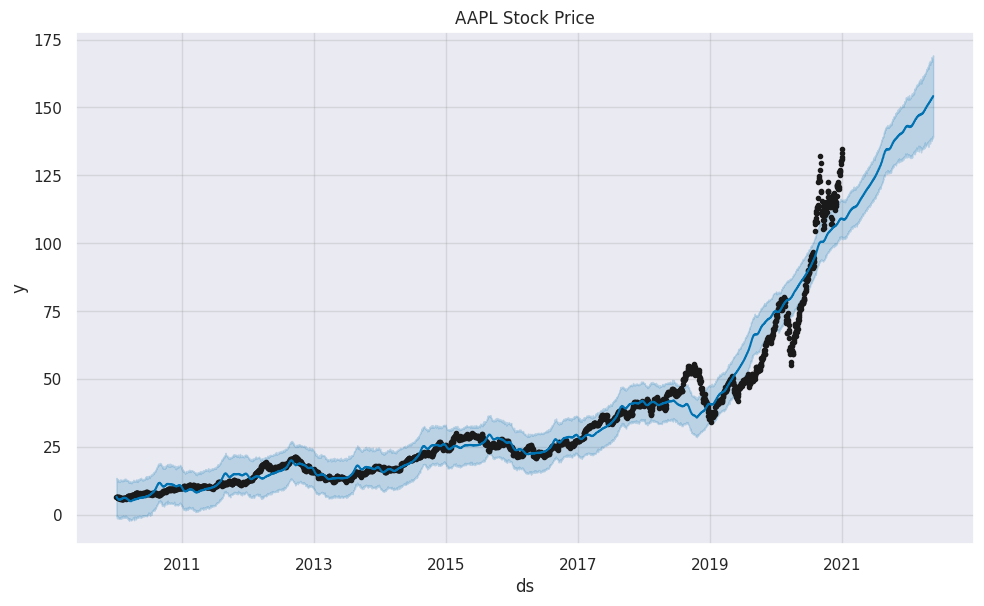

In [29]:
prices_model.plot(prices_predictions_df)
plt.title('AAPL Stock Price')
plt.show()

In [30]:
# Interactive plot
plot_plotly(prices_model, prices_predictions_df)

 Apple went public on December 12, 1980, with an IPO price of $22 per share. In the following years, the stock price fluctuated, influenced by various factors such as product launches, financial performance, and market conditions. The price started to increase over the years, however Apple's stock price was not immune to the effects of the global financial crisis in 2008. Following the recession, Apple's stock price embarked on a period of consistent growth. Fluctuations in the price can be justified also because Apple has undergone multiple stock splits throughout its history. Notable splits include a 2-for-1 split in 2000, a 7-for-1 split in 2014, and a 4-for-1 split in 2020. These splits increased the number of shares outstanding and reduced the stock price accordingly, making it more accessible to a wider range of investors.

The plot above can be described according to the following components:

*   black dots dispalys actual measurements
*   blue line is Prophet’s forecast
*   light blue boundaries indicates confidence intervals


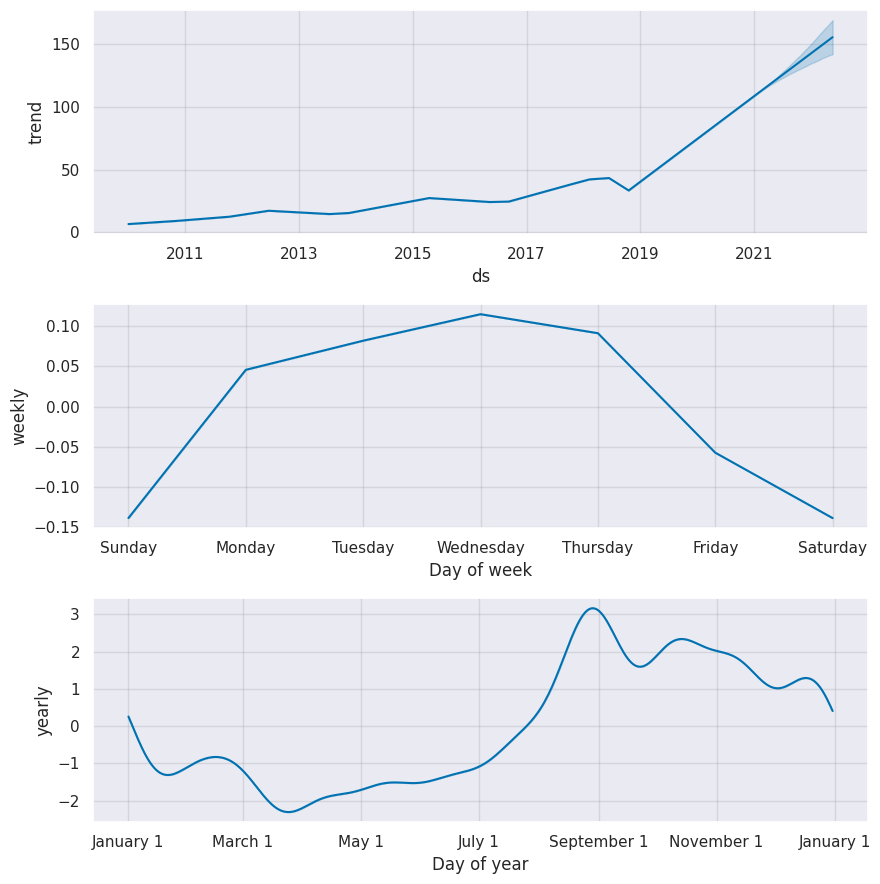

In [31]:
# Get the components
prices_model.plot_components(prices_predictions_df)
plt.show()

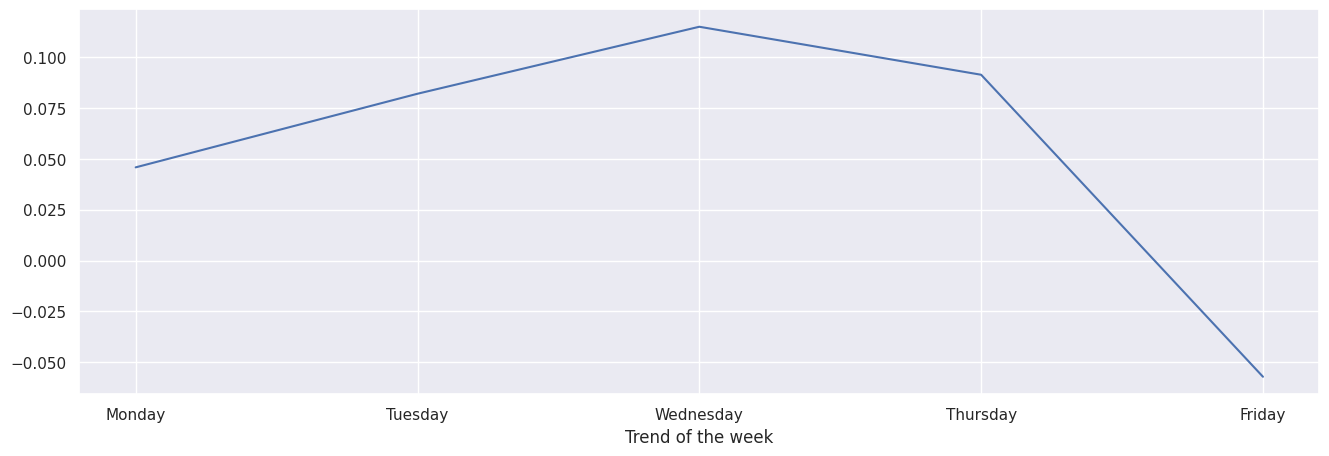

In [32]:
s = 0
while(True):
  if prices_predictions_df.ds[s].weekday() == 0:
    break
  else:
    s +=  1

e = s + 5

days = prices_predictions_df.ds[s:e]
weekly_seasonality = prices_predictions_df.weekly[s:e]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(np.arange(5), weekly_seasonality)
ax.set_xticks(np.arange(5))
ax.set_xticklabels(days.dt.day_name())
ax.set_xlabel('Trend of the week')

plt.show()

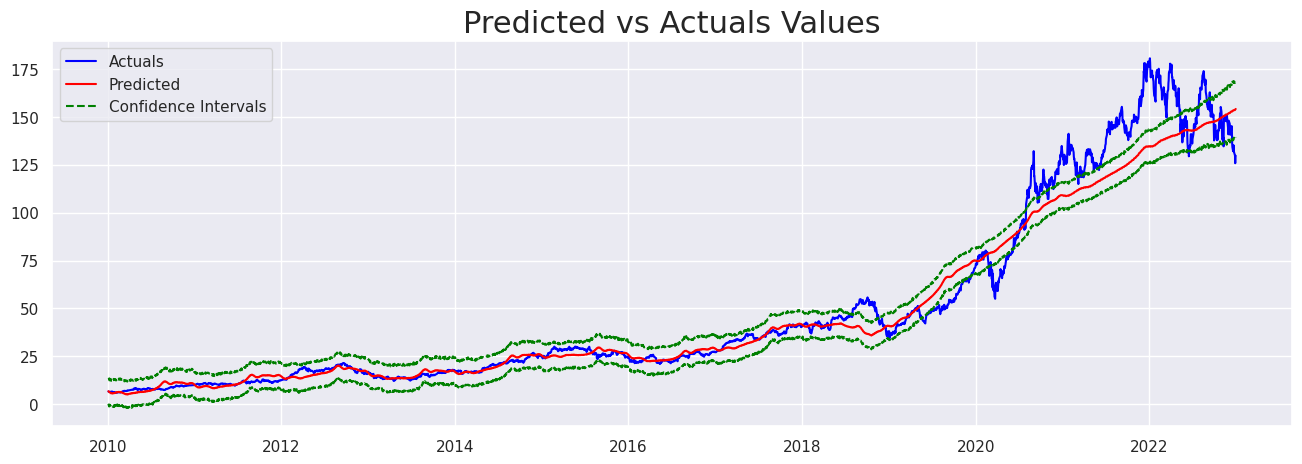

In [33]:
plt.rcParams["figure.figsize"] = 16, 5

plt.plot(data["Adj Close"], color = "blue", label = "Actuals")
plt.plot(data.index, prices_predictions_df["yhat"], color = "red", label = "Predicted")
plt.plot(data.index, prices_predictions_df["yhat_lower"], color = "green", linestyle = "--", label = "Confidence Intervals")
plt.plot(data.index, prices_predictions_df["yhat_upper"], color = "green", linestyle = "--")

plt.title("Predicted vs Actuals Values", size = 22)
plt.legend()
plt.show()

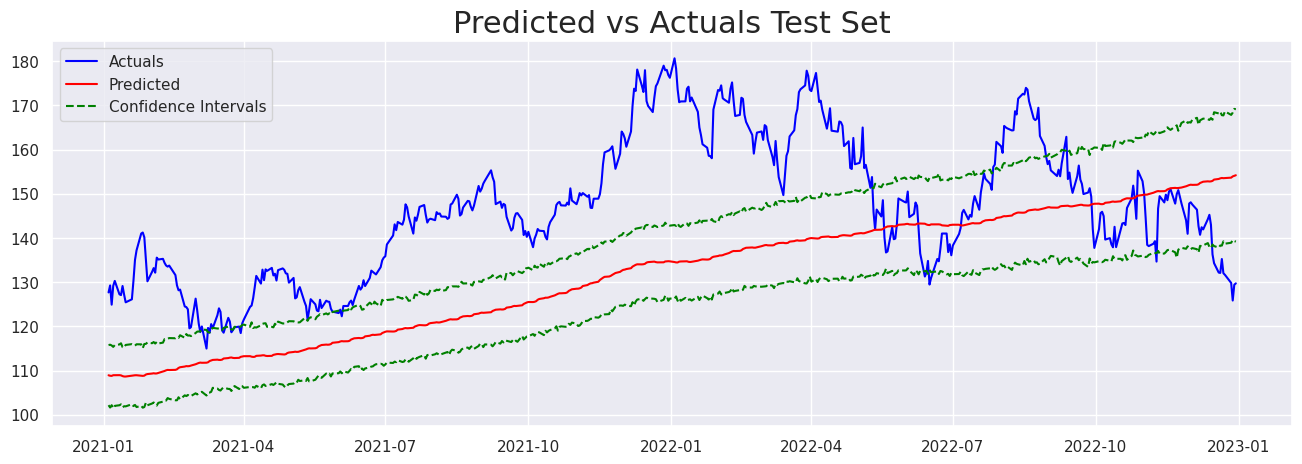

In [34]:
plt.rcParams["figure.figsize"] = 16, 5

plt.plot(test_df["Adj Close"], color = "blue", label = "Actuals")
plt.plot(test_df.index, prices_predictions_df.loc[prices_train_df.index[-1]+1:]["yhat"], color = "red", label = "Predicted")
plt.plot(test_df.index, prices_predictions_df.loc[prices_train_df.index[-1]+1:]["yhat_lower"], color = "green", linestyle = "--", label = "Confidence Intervals")
plt.plot(test_df.index, prices_predictions_df.loc[prices_train_df.index[-1]+1:]["yhat_upper"], color = "green", linestyle = "--")

plt.title("Predicted vs Actuals Test Set", size = 22)
plt.legend()
plt.show()

### Get the MSE and RMSE

In [35]:
y_true = prices_test_df["y"].values
y_pred = prices_predictions_df["yhat"][-len(prices_test_df.index):].values
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("MSE:", mse)
print("RMSE:", rmse)

MSE: 428.5163402024402
RMSE: 20.700636226996508


### Cross-validation

In [ ]:
# Use cross-validation on prices
df_cv_prices = cross_validation(prices_model, initial='2768 days', period='90 days', horizon = '14 days')
df_cv_prices.head()
df_cv_prices.tail()

In [37]:
df_p = performance_metrics(df_cv_prices)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,2 days,50.588076,7.112530,4.221412,0.063024,0.046575,0.065609,0.461538
1,3 days,107.048843,10.346441,7.405888,0.110299,0.052589,0.114237,0.367521
2,4 days,163.067655,12.769795,9.740899,0.123849,0.099537,0.132266,0.333333
3,5 days,151.558834,12.310923,8.733506,0.110123,0.090198,0.114382,0.461538
4,6 days,144.605979,12.025223,8.450683,0.117411,0.075796,0.116464,0.423077
5,7 days,158.747416,12.599501,8.792718,0.124126,0.091921,0.124591,0.400000
6,8 days,88.382801,9.401213,5.426167,0.081014,0.027316,0.084030,0.615385
7,9 days,43.741121,6.613707,3.556780,0.055108,0.023000,0.058480,0.615385
8,10 days,137.776233,11.737812,8.286582,0.125091,0.084664,0.128177,0.282051
9,11 days,223.146645,14.938094,11.033762,0.145890,0.212244,0.150904,0.276923


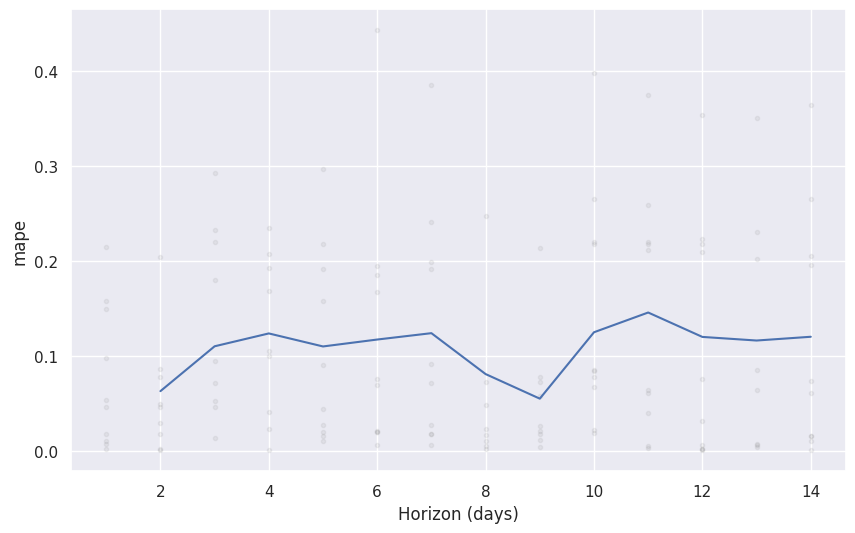

In [38]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv_prices, metric = 'mape')

### Conclusion
In this notebook, FB Prophet is used to investigate log returns and adjusted prices of AAPL stock. In particular, we observe that Prophet does pretty well when dealing with log returns, which are almost scattered around zero, whereas when using Adjusted Close prices, it is able to capture the increasing trend, however it is less accurate as confirmed by the metrics. Parameter grid is not included in this notebbok, however it has been performed behind the scene, without improving too much the results but increasingly the computational complexity of the model. Moreover, in order to improve the performance of the model, one has to provide to Prophet more information about seasonality, growth and holidays or special events that had a significant impact on the company.